# Loading Data

In [1]:
# Importing basic libraries
import gc
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
%matplotlib inline

# Importing sklearn libraries
from sklearn import preprocessing
from sklearn import metrics

# import lightgbm model
import lightgbm as lgb

# Others
from tqdm import tqdm_notebook
from typing import List
import warnings
warnings.filterwarnings('ignore')
import datetime
import feather

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# loading datasets
train_2015 = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/2015_sales_data.csv', parse_dates=['date'])
train_2016 = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/2016_sales_data.csv', parse_dates=['date'])
train_2017 = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/2017_sales_data.csv', parse_dates=['date'])
train_2018 = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/2018_sales_data.csv', parse_dates=['date'])
test = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/test_data.csv', parse_dates=['date'])
submission = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/sample_submission.csv')
product_info = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/product_information.csv')
hist_disc = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/historical_discount.csv', parse_dates=['date'])
exp_disc = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/expected_discount.csv', parse_dates=['date'])
foot_fall = pd.read_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/foot_fall.csv')
f = open('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/city_dict.json',) 
city_dict = json.load(f) 

In [ ]:
train_2015.head()

,date,city,product,sales
0,2015-01-02,1,1,24.0
1,2015-01-02,1,2,144.0
2,2015-01-02,1,3,84.0
3,2015-01-02,1,4,24.0
4,2015-01-02,1,5,8.0


In [ ]:
train_2018.tail()

,date,city,product,sales
2923421,2018-04-30,10,3163,4.0
2923422,2018-04-30,10,3164,44.0
2923423,2018-04-30,10,3157,16.0
2923424,2018-04-30,10,3165,88.0
2923425,2018-04-30,10,3057,32.0


Overall, training data daily sales at city-product level (I would validate this later) from January 2015 to April 2018. 

In [3]:
# Appending all training sales into one file
train=pd.concat([train_2015,train_2016,train_2017,train_2018],axis=0,ignore_index=True)
del train_2015, train_2016, train_2017, train_2018

In [ ]:
train.head()

,date,city,product,sales
0,2015-01-02,1,1,24.0
1,2015-01-02,1,2,144.0
2,2015-01-02,1,3,84.0
3,2015-01-02,1,4,24.0
4,2015-01-02,1,5,8.0


In [ ]:
train.tail()

,date,city,product,sales
21135740,2018-04-30,10,3163,4.0
21135741,2018-04-30,10,3164,44.0
21135742,2018-04-30,10,3157,16.0
21135743,2018-04-30,10,3165,88.0
21135744,2018-04-30,10,3057,32.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21135745 entries, 0 to 21135744
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   city     int64         
 2   product  int64         
 3   sales    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 645.0 MB


In [4]:
test.tail()

,id,date,city,product
2262130,2262131,2018-07-31,10,3163
2262131,2262132,2018-07-31,10,3164
2262132,2262133,2018-07-31,10,3157
2262133,2262134,2018-07-31,10,3165
2262134,2262135,2018-07-31,10,3057


# Exploratory Data Analysis

Let's start by doing some basic validation on test and training datasets. The data seems to be at data-city-product level. Let's check if that really is the case.

In [5]:
# checking if training data is unique ar date-city-product level
train.groupby(['date','city','product'])['sales'].sum().reset_index().shape

(21113141, 4)

The number of rows are less than what were there in the raw dataset! Let's do the same check on test dataset.

In [4]:
test['sales'] = 0
test_new=test[['date', 'city', 'product','sales']]

# checking if training data is unique ar date-city-product level
test_new.groupby(['date','city','product'])['sales'].sum().reset_index().shape

(2262135, 4)

The test dataset though, is indeed at date-city-product level. <br>

To maintain consistency between test and training data, I'm rolling up sales in train data at date-city-product level

In [5]:
# rolling up train data at date-city-product level
train=train.groupby(['date','city','product'])['sales'].sum().reset_index()

train.tail()

,date,city,product,sales
21113136,2018-04-30,10,3317,24.0
21113137,2018-04-30,10,3318,36.0
21113138,2018-04-30,10,3319,16.0
21113139,2018-04-30,10,3321,16.0
21113140,2018-04-30,10,3322,16.0


In [6]:
# appending test and train datasets for maintaining consistency of features
train['train_or_test'] = 'train'
test_new['train_or_test'] = 'test'
combined_df=pd.concat([train,test_new],axis=0,ignore_index=True)
print('Combined df shape:{}'.format(combined_df.shape))
del train, test_new
gc.collect()

Combined df shape:(23375276, 5)


22

In [11]:
combined_df.tail()

,date,city,product,sales,train_or_test
23375271,2018-07-31,10,3163,0.0,test
23375272,2018-07-31,10,3164,0.0,test
23375273,2018-07-31,10,3157,0.0,test
23375274,2018-07-31,10,3165,0.0,test
23375275,2018-07-31,10,3057,0.0,test


Now that I have combined the test and train datasets, I can move on to create some date related features. Usually, sales data has seasonality so these features might be useful (I would validate this later)

In [7]:
# extracting date related features
combined_df['dayofmonth'] = combined_df.date.dt.day
combined_df['dayofyear'] = combined_df.date.dt.dayofyear
combined_df['dayofweek'] = combined_df.date.dt.dayofweek
combined_df['month'] = combined_df.date.dt.month
combined_df['year'] = combined_df.date.dt.year
combined_df['weekofyear'] = combined_df.date.dt.weekofyear
combined_df['weekofmonth'] = (combined_df['dayofmonth'] - 1) // 7 + 1
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1


In [13]:
combined_df.tail()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth
23375271,2018-07-31,10,3163,0.0,test,31,212,1,7,2018,31,5
23375272,2018-07-31,10,3164,0.0,test,31,212,1,7,2018,31,5
23375273,2018-07-31,10,3157,0.0,test,31,212,1,7,2018,31,5
23375274,2018-07-31,10,3165,0.0,test,31,212,1,7,2018,31,5
23375275,2018-07-31,10,3057,0.0,test,31,212,1,7,2018,31,5


## The target variable: sales

First things first, let's create some distributions on our target variable - sales

Text(0.5, 1.0, 'Sales Histogram')

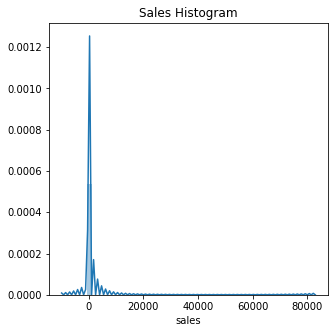

In [14]:
# histogram on sales
plt.figure(figsize=(5,5))
sns.distplot(combined_df.loc[combined_df['train_or_test']=='train','sales'])
plt.title('Sales Histogram')

The wide spread of the above histogram indicates that outliers are possibly present

In [15]:
# top 20 sales values
largest = combined_df.nlargest(20, ['sales'])
largest

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth
20807026,2018-04-18,5,518,82992.000,train,18,108,2,4,2018,16,3
20879799,2018-04-21,5,198,48912.000,train,21,111,5,4,2018,16,3
4476419,2015-12-21,9,861,48084.000,train,21,355,0,12,2015,52,3
20806546,2018-04-18,5,2,44128.000,train,18,108,2,4,2018,16,3
4764358,2016-01-10,5,1299,40000.000,train,10,10,6,1,2016,1,2
8026414,2016-08-01,5,1239,36012.000,train,1,214,0,8,2016,31,1
14923319,2017-08-11,4,2236,32036.000,train,11,223,4,8,2017,32,2
10750293,2016-12-24,6,1342,30127.724,train,24,359,5,12,2016,51,4
4502093,2015-12-23,6,1342,28202.000,train,23,357,2,12,2015,52,4
436476,2015-02-08,5,77,28004.000,train,8,39,6,2,2015,6,2


At first glance, these sales (specially first 5-10 or so) look like outliers. These could be sales of utility products (e.g carry bags etc.) that go out with every sale. Even considering that, the sales are unusually high. <br>
However, many of these sales are either towards the end of year or around march-april. So I cannot be sure if these are indeed outliers without exploring that expect.

In [16]:
# grouping these top 20 products based on their median sales in each month
grouped_big_prod=combined_df[combined_df['product'].isin(largest['product'])].groupby(['product','month'])['sales'].median().rename('median_sales').reset_index()
pd.pivot_table(grouped_big_prod, values='median_sales', index='product', columns='month', aggfunc=np.sum)

month,1,2,3,4,5,6,7,8,9,10,11,12
product,,,,,,,,,,,,
2,56.000,56.000,68.000,68.000,44.000,44.000,44.000,64.000,60.000,52.000,60.000,76.000
77,16.000,16.000,12.000,12.000,0.000,0.000,0.000,12.000,12.000,16.000,12.000,16.000
198,304.000,292.000,292.000,312.000,216.000,218.000,244.000,342.000,360.000,304.000,316.000,316.000
412,81.316,42.852,42.516,41.562,40.554,40.360,37.878,40.640,41.026,41.962,75.936,859.552
466,96.000,92.000,96.000,96.000,68.000,64.000,80.000,100.000,88.000,84.000,88.000,104.000
518,280.000,276.000,264.000,268.000,200.000,192.000,168.000,254.000,256.000,252.000,244.000,292.000
861,53.852,54.242,52.308,55.600,49.960,53.788,47.664,54.262,52.060,54.768,56.864,145.452
930,32.000,32.000,28.000,32.000,16.000,16.000,20.000,32.000,32.000,32.000,28.000,32.000
952,24.000,20.000,24.000,24.000,12.000,12.000,12.000,24.000,28.000,24.000,24.000,32.000


In [17]:
del grouped_big_prod, largest
gc.collect()

33

While the median sales do increase towards the end of the year for many products, the median is no where near the big sales values we are getting. I can safely assume that these super-high sales are just a few anomalous entries. These should be removed. 

In [ ]:
# checking the top 50 highest sales
combined_df.nlargest(50, ['sales'])

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth
20829694,2018-04-18,5,518,82992.000,train,18,108,2,4,2018,16,3
20902418,2018-04-21,5,198,48912.000,train,21,111,5,4,2018,16,3
4476514,2015-12-21,9,861,48084.000,train,21,355,0,12,2015,52,3
20829151,2018-04-18,5,2,44128.000,train,18,108,2,4,2018,16,3
4763522,2016-01-10,5,1299,40000.000,train,10,10,6,1,2016,1,2
8025960,2016-08-01,5,1239,36012.000,train,1,214,0,8,2016,31,1
14923041,2017-08-11,4,2236,32036.000,train,11,223,4,8,2017,32,2
10749665,2016-12-24,6,1342,30127.724,train,24,359,5,12,2016,51,4
4501444,2015-12-23,6,1342,28202.000,train,23,357,2,12,2015,52,4
436481,2015-02-08,5,77,28004.000,train,8,39,6,2,2015,6,2


The sales numbers seem to stabilize a little once getting below the 15,000 mark.

In [8]:
# removing all entries with sales greater than 15,000
combined_df = combined_df[combined_df['sales'] < 15000]
combined_df.shape

(23375237, 12)

The histogram also shows that some entries have negative sales. Let's check how many such entries are there.

In [19]:
combined_df[combined_df['sales'] < 0].shape

(1550, 12)

~1,500 entries have negative sales! These can possibly be returns so we shoudn't directly remove them. However, let's check if some entries with very high negative sales are present here. Those could be anomalies.

In [ ]:
combined_df.nsmallest(50, ['sales'])

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth
20980903,2018-04-24,6,2472,-9948.000,train,24,114,1,4,2018,17,4
14457066,2017-07-20,9,1144,-9600.000,train,20,201,3,7,2017,29,3
17827808,2017-12-15,4,167,-7224.000,train,15,349,4,12,2017,50,3
7550006,2016-07-07,5,792,-5804.000,train,7,189,3,7,2016,27,1
20898738,2018-04-21,3,2401,-3968.000,train,21,111,5,4,2018,16,3
20898629,2018-04-21,3,1749,-3956.000,train,21,111,5,4,2018,16,3
20898739,2018-04-21,3,2399,-3940.000,train,21,111,5,4,2018,16,3
20897371,2018-04-21,3,22,-2664.000,train,21,111,5,4,2018,16,3
20979453,2018-04-24,6,451,-1988.000,train,24,114,1,4,2018,17,4
20905018,2018-04-21,6,352,-1976.000,train,21,111,5,4,2018,16,3


There are some unusually high returns here. These could possibly be cases where a faulty product was sold in high numbers and led to high returns. However, such cases are rare and can be considered as an anomaly. The numbers seem to stabilize at -400 mark.

In [9]:
# removing all entries with sales less than 400
combined_df = combined_df[combined_df['sales'] > -400]
combined_df.shape

(23375204, 12)

## Checking for seasonality

Earlier, I created some date related features. These features can be useful if seasonality is present within the data, let's validate that by creating some visuals.

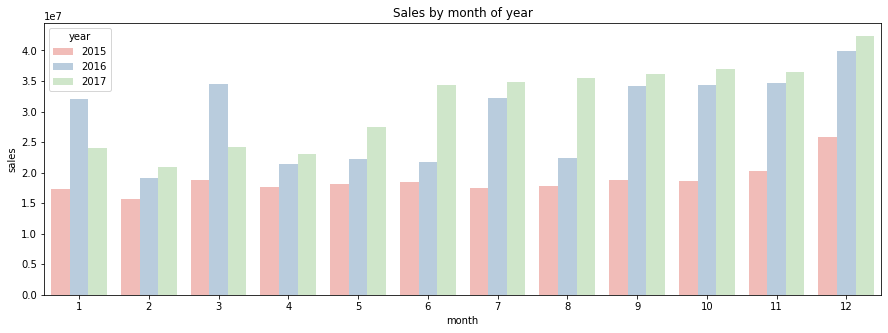

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.set_palette('Pastel1')

# sales by month of year
plt.title('Sales by month of year')
sns.barplot(data=combined_df[(combined_df['train_or_test'] == 'train') & (combined_df['year'] < 2018)].groupby(['month','year'])['sales'].sum().reset_index(),x='month',y='sales',hue='year')

Sales tend to be higher towards the end of the year. This makes sense since that is the holiday season.

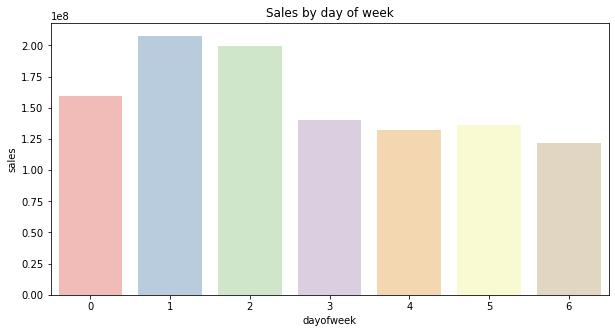

In [ ]:
fig = plt.figure(figsize=(10,5))

# sales by day of week
plt.title('Sales by day of week')
sns.barplot(data=combined_df[(combined_df['train_or_test'] == 'train')].groupby('dayofweek')['sales'].sum().reset_index(),x='dayofweek',y='sales')


Apparantly, sales are highest on tuesdays and wednesdays.

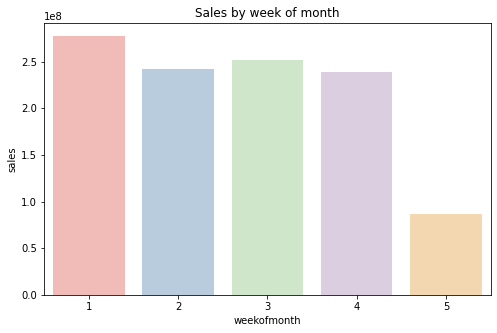

In [ ]:
fig = plt.figure(figsize=(8,5))

# sales by week of month
plt.title('Sales by week of month')
sns.barplot(data=combined_df[(combined_df['train_or_test'] == 'train')].groupby('weekofmonth')['sales'].sum().reset_index(),x='weekofmonth',y='sales')

Salaried people tend to spend more during the first week of the month. Therefore, the above chart makes sense :)

We have also have city information within the dataset. Although, this is not related to seasonality, it would be interesting to check which cities have the highest sales.

In [ ]:
# checking how the city mapping looks
city_dict

{'1': 'Kolkata',
 '10': 'Lucknow',
 '2': 'Other',
 '3': 'Jaipur',
 '4': 'Mumbai',
 '5': 'Delhi',
 '6': 'Chennai',
 '7': 'Bangalore',
 '8': 'Hyderabad',
 '9': 'Ahmedabad'}

In [10]:
# converting city codes to integer type so that they can be mapped to the dataframe
city_dict = {int(key):val 
       for key, val in city_dict.items()} 

city_dict

{1: 'Kolkata',
 2: 'Other',
 3: 'Jaipur',
 4: 'Mumbai',
 5: 'Delhi',
 6: 'Chennai',
 7: 'Bangalore',
 8: 'Hyderabad',
 9: 'Ahmedabad',
 10: 'Lucknow'}

In [11]:
# mapping city names to city codes
combined_df['city_name'] = combined_df['city'].map(city_dict)
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1,Kolkata
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1,Kolkata
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1,Kolkata
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1,Kolkata
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1,Kolkata


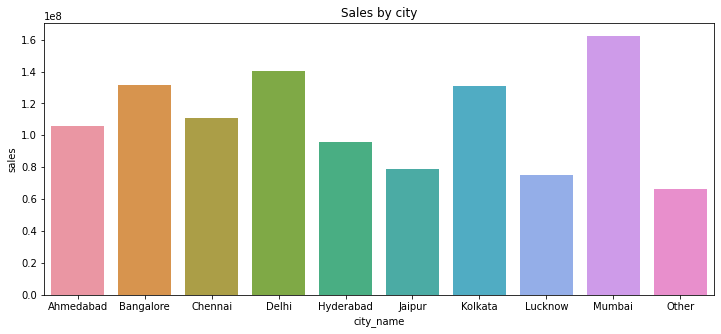

In [ ]:
fig = plt.figure(figsize=(12,5))
sns.set_palette('Pastel1')

# sales by city
plt.title('Sales by city')
sns.barplot(data=combined_df[(combined_df['train_or_test'] == 'train')].groupby('city_name')['sales'].sum().reset_index(),x='city_name',y='sales')

Gift Cart sells the most in Mumbai, Delhi, Bangalore and Kolkata in that order.

In [12]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375275
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   city           int64         
 2   product        int64         
 3   sales          float64       
 4   train_or_test  object        
 5   dayofmonth     int64         
 6   dayofyear      int64         
 7   dayofweek      int64         
 8   month          int64         
 9   year           int64         
 10  weekofyear     int64         
 11  weekofmonth    int64         
 12  city_name      object        
dtypes: datetime64[ns](1), float64(1), int64(9), object(2)
memory usage: 2.4+ GB


Before moving ahead, we should address that we are dealing with a large dataset and it can often crash during processing if we don't deal with the dataset size. I am going to downcast the column datatypes to reduce dataset size.

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to lowest possible float without data loss
                `int64`   type to lowest possible int wihtout data loss
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    del float_cols
    del int_cols
    
    return df

In [13]:
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375275
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   city           int8          
 2   product        int16         
 3   sales          float32       
 4   train_or_test  object        
 5   dayofmonth     int8          
 6   dayofyear      int16         
 7   dayofweek      int8          
 8   month          int8          
 9   year           int16         
 10  weekofyear     int8          
 11  weekofmonth    int8          
 12  city_name      object        
dtypes: datetime64[ns](1), float32(1), int16(3), int8(6), object(2)
memory usage: 1.0+ GB


Dataset size has reduced significantly.

In [24]:
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1,Kolkata
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1,Kolkata
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1,Kolkata
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1,Kolkata
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1,Kolkata


## Product Information

We have a file with product information, let's see which useful information we can extract from there. We also need to check if there are any issues with the product codes in the test and train datasets.

In [ ]:
product_info.head()

,product,product_category,product_subcategory,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
0,1,Cat_753,SubCat_3077,0.715514,0.299219,0.381067,0.0003,0.363847,0.300629,0.08,0.416806,1.171543,0.668805
1,2,Cat_643,SubCat_3774,0.075851,0.298774,0.852691,0.0003,0.409503,0.465912,0.08,0.545467,0.541547,0.401800
2,3,Cat_2804,SubCat_7454,0.285910,0.308168,0.531137,0.0003,0.168459,0.517364,0.08,0.521452,0.945024,0.631538
3,4,Cat_71,SubCat_5,0.544437,0.281760,0.530937,0.0003,0.291839,0.302639,0.08,0.519929,0.635492,0.991901
4,5,Cat_1556,SubCat_9403,0.852752,0.301493,0.343009,0.0003,0.286037,0.822326,0.08,0.462138,0.574709,0.792799


In [ ]:
product_info.describe()

,product,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
count,3389.000000,3389.000000,3389.000000,3389.000000,3.389000e+03,3389.000000,3389.000000,3.389000e+03,3389.000000,3389.000000,3389.000000
mean,1695.000000,0.502423,0.300025,0.599648,3.000000e-04,0.349260,0.603023,8.000000e-02,0.499604,0.806147,0.702047
std,978.464358,0.286178,0.010287,0.198647,1.209064e-17,0.142723,0.174802,4.316629e-15,0.049441,0.304240,0.172882
min,1.000000,0.000936,0.263040,-0.147385,3.000000e-04,0.100090,0.300160,8.000000e-02,0.332469,-0.294912,0.400015
25%,848.000000,0.253101,0.293168,0.470882,3.000000e-04,0.225308,0.454379,8.000000e-02,0.465838,0.601223,0.551492
50%,1695.000000,0.498743,0.299938,0.599964,3.000000e-04,0.349353,0.601717,8.000000e-02,0.499734,0.809121,0.703019
75%,2542.000000,0.748209,0.306943,0.733991,3.000000e-04,0.473972,0.756619,8.000000e-02,0.532564,1.013195,0.854160
max,3389.000000,0.999823,0.334948,1.256447,3.000000e-04,0.599972,0.899998,8.000000e-02,0.644091,1.980311,0.999983


From the table above, we can see that 'var_4' and 'var_7' have only one value in all rows. This won't be useful for our problem. Let's remove these columns. <br>
Additionally, on the other var columns, I can see varying distributions. These columns should be scaled.

In [15]:
# dropping var_4 and var_7 which have only a single value
product_info.drop(['var_4', 'var_7'], axis = 1,inplace = True) 
product_info.head()

,product,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10
0,1,Cat_753,SubCat_3077,0.715514,0.299219,0.381067,0.363847,0.300629,0.416806,1.171543,0.668805
1,2,Cat_643,SubCat_3774,0.075851,0.298774,0.852691,0.409503,0.465912,0.545467,0.541547,0.401800
2,3,Cat_2804,SubCat_7454,0.285910,0.308168,0.531137,0.168459,0.517364,0.521452,0.945024,0.631538
3,4,Cat_71,SubCat_5,0.544437,0.281760,0.530937,0.291839,0.302639,0.519929,0.635492,0.991901
4,5,Cat_1556,SubCat_9403,0.852752,0.301493,0.343009,0.286037,0.822326,0.462138,0.574709,0.792799


In [ ]:
product_info.columns

Index(['product', 'product_category', 'product_subcategory', 'var_1', 'var_2',
       'var_3', 'var_5', 'var_6', 'var_8', 'var_9', 'var_10'],
      dtype='object')

In [16]:
# scaling remaining var variables
product_info[['var_1', 'var_2','var_3', 'var_5', 'var_6', 'var_8', 'var_9', 'var_10']] = preprocessing.scale(product_info[['var_1', 'var_2','var_3', 'var_5', 'var_6', 'var_8', 'var_9', 'var_10']])
product_info.describe()

,product,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10
count,3389.000000,3.389000e+03,3.389000e+03,3.389000e+03,3.389000e+03,3.389000e+03,3.389000e+03,3.389000e+03,3.389000e+03
mean,1695.000000,1.502683e-16,-1.406173e-15,1.081067e-17,8.877853e-18,6.768134e-16,-7.157810e-16,-3.950808e-17,1.162311e-16
std,978.464358,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00
min,1.000000,-1.752617e+00,-3.596045e+00,-3.761151e+00,-1.746085e+00,-1.732862e+00,-3.381015e+00,-3.619580e+00,-1.747307e+00
25%,848.000000,-8.713387e-01,-6.667226e-01,-6.483063e-01,-8.686085e-01,-8.504806e-01,-6.830664e-01,-6.736596e-01,-8.709867e-01
50%,1695.000000,-1.285871e-02,-8.486354e-03,1.590371e-03,6.474256e-04,-7.470801e-03,2.630919e-03,9.777206e-03,5.619034e-03
75%,2542.000000,8.589845e-01,6.726419e-01,6.763904e-01,8.739301e-01,8.788163e-01,6.667471e-01,6.806404e-01,8.799950e-01
max,3389.000000,1.738334e+00,3.395532e+00,3.306845e+00,1.756888e+00,1.699179e+00,2.922868e+00,3.859899e+00,1.723602e+00


product_Category and product_subcategory columns have category numbers within them. Let's exract these numbers.

In [17]:
# extracting numbers from category columns
product_info['product_category'] = product_info.product_category.str.extract('(\d+)', expand=False).astype(str).astype(int)
product_info['product_subcategory'] = product_info.product_subcategory.str.extract('(\d+)', expand=False).astype(str).astype(int)
product_info.head()

,product,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10
0,1,753,3077,0.744720,-0.078443,-1.100509,0.102221,-1.730180,-1.674934,1.201186,-0.192315
1,2,643,3774,-1.490801,-0.121626,1.274018,0.422160,-0.784495,0.927770,-0.869836,-1.736978
2,3,2804,7454,-0.756675,0.791708,-0.344938,-1.266979,-0.490108,0.441964,0.456539,-0.407910
3,4,71,5,0.146832,-1.775928,-0.345945,-0.402385,-1.718680,0.411161,-0.561005,1.676849
4,5,1556,9403,1.224347,0.142679,-1.292124,-0.443043,1.254772,-0.757901,-0.760821,0.525014


Before joining these values to our main dataset, let's check if product information for all the products in the main dataset is present here.

In [ ]:
# checking if products in combined dataset are a subset of products in the product information file
items_combined_list = list(combined_df['product'].unique())
items_prodinfo_list = list(product_info['product'].unique())

flag = 0
if(set(items_combined_list).issubset(set(items_prodinfo_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is a subset") 
else : 
    print ("No, list is not a subset") 

No, list is not a subset


Product information for all products in the combined dataset is not present. Let's check how many such products are there and which products are these.

In [ ]:
# extracting the products in combined data for which product info is not present
noProdInfo = np.setdiff1d(items_combined_list,items_prodinfo_list)
noProdInfo

array([3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400,
       3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411,
       3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422,
       3423])

In [ ]:
noProdInfo.shape

(34,)

There are 34 such products. Moreover, these are continuous numbers starting 3390. Let's check other information for these products.

In [ ]:
# filtering for all rows having products with no product info
missing_products = combined_df[combined_df['product'] > 3389]

list(missing_products['train_or_test'].unique())

['test']

All the products with missing info are present in test data! Let's check if there are other products which are present in test data but absent from training data.

In [ ]:
# checking if there are some products in test data which 
items_train_list = list(combined_df.loc[combined_df['train_or_test']=='train','product'].unique())
items_test_list = list(combined_df.loc[combined_df['train_or_test']=='test','product'].unique())

noTrainProds = np.setdiff1d(items_test_list,items_train_list)
noTrainProds

array([3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335,
       3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346,
       3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357,
       3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368,
       3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379,
       3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390,
       3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401,
       3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412,
       3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423])

In [ ]:
noTrainProds.shape

(99,)

There are 99 products which are absent from training data but present in testing data. Out of these, product info is present for (99-34)=65 products. <br>
Again, all these 99 products have continuos product IDs starting 3325. <br>
These could be products which were added to the directory (new products) after April 2018 (when our test period starts). <br>

For these 99 products which are present in test data but absent from training datam, I'm diving this problem into two parts:


1.   65 products with product info present: I can't think of much we can do about these products from feature engineering POV. At a product level, we have all the info present for these. I would just trust my final model to make fair predictions for these.
2.   34 product with no product info: For these, filling the missing info makes sense. One way to go about it could be to fill-in the info for most popular products (based on sales), but this can inflate sales since these products would usually be selling more. Therefore, I feel simply using the mean values and the most common categories (based on # of products) is the best way to go.



In [ ]:
# identifyng most common product categories and subcategories

# most common categories
product_info.groupby('product_category')['product'].count().rename('product_counts').reset_index().nlargest(10, ['product_counts'])

,product_category,product_counts
1460,3301,6
116,1185,5
281,1443,5
650,2032,5
1002,2575,5
1324,3081,5
1633,3564,5
2229,879,5
14,102,4
111,1176,4


In [ ]:
# most common sub-categories
product_info.groupby('product_subcategory')['product'].count().rename('product_counts').reset_index().nlargest(10, ['product_counts'])

,product_subcategory,product_counts
2696,9457,5
425,2438,4
514,2728,4
561,2870,4
695,3354,4
787,3618,4
1411,5513,4
1724,6415,4
1868,6821,4
8,1030,3


In [ ]:
del noTrainProds
del items_test_list
del items_train_list
del missing_products
del noProdInfo
del items_combined_list
del items_prodinfo_list

gc.collect()

First, let's join product info to combined data.

In [18]:
combined_df = pd.merge(combined_df, product_info, on=['product'], how='left')

In [29]:
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1,Kolkata,753.0,3077.0,0.744720,-0.078443,-1.100509,0.102221,-1.730180,-1.674934,1.201186,-0.192315
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1,Kolkata,643.0,3774.0,-1.490801,-0.121626,1.274018,0.422160,-0.784495,0.927770,-0.869836,-1.736978
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1,Kolkata,2804.0,7454.0,-0.756675,0.791708,-0.344938,-1.266979,-0.490108,0.441964,0.456539,-0.407910
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1,Kolkata,71.0,5.0,0.146832,-1.775928,-0.345945,-0.402385,-1.718680,0.411161,-0.561005,1.676849
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1,Kolkata,1556.0,9403.0,1.224347,0.142679,-1.292124,-0.443043,1.254772,-0.757901,-0.760821,0.525014


In [30]:
combined_df.dtypes

date                   datetime64[ns]
city                             int8
product                         int16
sales                         float32
train_or_test                  object
dayofmonth                       int8
dayofyear                       int16
dayofweek                        int8
month                            int8
year                            int16
weekofyear                       int8
weekofmonth                      int8
city_name                      object
product_category              float64
product_subcategory           float64
var_1                         float64
var_2                         float64
var_3                         float64
var_5                         float64
var_6                         float64
var_8                         float64
var_9                         float64
var_10                        float64
dtype: object

Again, the dataset size is getting too large. Let's downcast the variables to reduce size. <br>
However, this time we don't want to directly downcast to float 16 since our var_x variables have values to large number of decimal places. Therefore, I'm creating a separate fucntion to instead downcast to float32. This can be a tradoff we can work with.

In [19]:
combined_df = downcast_dtypes(combined_df)
gc.collect()

44

In [20]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        object        
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  city_name            object        
 13  product_category     float32       
 14  product_subcategory  float32       
 15  var_1                float32       
 16  var_2                float32       
 17  var_3                float32       
 18  var_5                float32       
 19  var_6              

Now, let's fill blank values on var and categories columns that we determined above.

In [21]:
# fill missing values on var columns with zeroes (mean of var columns, as they were scaled)
combined_df[['var_1','var_2', 'var_3', 'var_5', 'var_6', 'var_8', 'var_9', 'var_10']].fillna(0, inplace=True)

In [22]:
# fill missing values on category column with most common category (3301)
combined_df['product_category'].fillna(3301, inplace=True)

# fill missing values on subcategory column with most common category (9457)
combined_df['product_subcategory'].fillna(9457, inplace=True)

In [23]:
# converting category columns to integer
combined_df.product_category = combined_df.product_category.astype(int)
combined_df.product_subcategory = combined_df.product_subcategory.astype(int)

In [24]:
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

In [25]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        object        
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  city_name            object        
 13  product_category     int16         
 14  product_subcategory  int16         
 15  var_1                float32       
 16  var_2                float32       
 17  var_3                float32       
 18  var_5                float32       
 19  var_6              

## Discounts

There are two discount files - historical_discount and expected_discount. Let's check if these cover our training and testing time period.

In [32]:
hist_disc.head()

,date,product,Discount_Ahmedabad,Discount_Bangalore,Discount_Chennai,Discount_Delhi,Discount_Hyderabad,Discount_Jaipur,Discount_Kolkata,Discount_Lucknow,Discount_Mumbai,Discount_Other
0,2016-04-29,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016-04-29,255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2016-04-29,316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016-04-29,594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2016-04-29,664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
hist_disc.tail()

,date,product,Discount_Ahmedabad,Discount_Bangalore,Discount_Chennai,Discount_Delhi,Discount_Hyderabad,Discount_Jaipur,Discount_Kolkata,Discount_Lucknow,Discount_Mumbai,Discount_Other
112748,2018-04-30,3293,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
112749,2018-04-30,3294,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
112750,2018-04-30,3298,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
112751,2018-04-30,3305,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
112752,2018-04-30,3307,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [34]:
exp_disc.head()

,date,product,Discount_Ahmedabad,Discount_Bangalore,Discount_Chennai,Discount_Delhi,Discount_Hyderabad,Discount_Jaipur,Discount_Kolkata,Discount_Lucknow,Discount_Mumbai,Discount_Other
0,2018-05-01,2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,2018-05-01,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2018-05-01,31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2018-05-01,32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2018-05-01,33,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [37]:
exp_disc.tail()

,date,product,Discount_Ahmedabad,Discount_Bangalore,Discount_Chennai,Discount_Delhi,Discount_Hyderabad,Discount_Jaipur,Discount_Kolkata,Discount_Lucknow,Discount_Mumbai,Discount_Other
30982,2018-07-31,3304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30983,2018-07-31,3305,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
30984,2018-07-31,3315,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
30985,2018-07-31,3353,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
30986,2018-07-31,3382,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


We have discount inforamtion at product-city level from ~May,2016 to July,2018. A few points to note here:
 

1.   We don't have discount information prior to May 2016. Since this period is very old and the files which were provided to us cover the whole time after that, I am assuming that disocunts prior to May 2016 were just not running, and Gift Cart started running discounts only after April 2016.
2.   Discount values are represented as 0 and 1. For the product-date-city combinations which are not listed in these files, we can just take the missing values as 0.
3.   Expected discounts cover discounts for the whole of test data period. Since these files were directly provided to us, I am not differentiating between the historical and expected discounts. Both would go into the same column.
4.   Since we already have the discounts for test data period, later we won't have to take the trouble of creating lag features for discounts.



Let's start by appending the histoorical and expected discounts

In [26]:
# appending historical and expected discounts
all_disc=pd.concat([hist_disc,exp_disc],axis=0,ignore_index=True)
all_disc.shape

(143740, 12)

In [27]:
del hist_disc, exp_disc
gc.collect()
all_disc.tail()

,date,product,Discount_Ahmedabad,Discount_Bangalore,Discount_Chennai,Discount_Delhi,Discount_Hyderabad,Discount_Jaipur,Discount_Kolkata,Discount_Lucknow,Discount_Mumbai,Discount_Other
143735,2018-07-31,3304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
143736,2018-07-31,3305,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
143737,2018-07-31,3315,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
143738,2018-07-31,3353,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
143739,2018-07-31,3382,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [42]:
all_disc.columns

Index(['date', 'product', 'Discount_Ahmedabad', 'Discount_Bangalore',
       'Discount_Chennai', 'Discount_Delhi', 'Discount_Hyderabad',
       'Discount_Jaipur', 'Discount_Kolkata', 'Discount_Lucknow',
       'Discount_Mumbai', 'Discount_Other'],
      dtype='object')

In [28]:
# moving columns to rows for ease of joining
all_disc = pd.melt(all_disc, id_vars=['date', 'product'], value_vars=['Discount_Ahmedabad', 'Discount_Bangalore','Discount_Chennai', 'Discount_Delhi', 'Discount_Hyderabad','Discount_Jaipur', 'Discount_Kolkata', 'Discount_Lucknow','Discount_Mumbai', 'Discount_Other'])
all_disc.head()

,date,product,variable,value
0,2016-04-29,45,Discount_Ahmedabad,0.0
1,2016-04-29,255,Discount_Ahmedabad,0.0
2,2016-04-29,316,Discount_Ahmedabad,0.0
3,2016-04-29,594,Discount_Ahmedabad,0.0
4,2016-04-29,664,Discount_Ahmedabad,0.0


In [29]:
# extracting city name from column 'variable'
all_disc[['disc','city_name']] = all_disc.variable.str.split("_",expand=True) 
all_disc.head()

,date,product,variable,value,disc,city_name
0,2016-04-29,45,Discount_Ahmedabad,0.0,Discount,Ahmedabad
1,2016-04-29,255,Discount_Ahmedabad,0.0,Discount,Ahmedabad
2,2016-04-29,316,Discount_Ahmedabad,0.0,Discount,Ahmedabad
3,2016-04-29,594,Discount_Ahmedabad,0.0,Discount,Ahmedabad
4,2016-04-29,664,Discount_Ahmedabad,0.0,Discount,Ahmedabad


In [30]:
# dropping columns 'variable' and 'disc'
all_disc.drop(['variable', 'disc'], axis = 1,inplace = True) 
all_disc.head()

,date,product,value,city_name
0,2016-04-29,45,0.0,Ahmedabad
1,2016-04-29,255,0.0,Ahmedabad
2,2016-04-29,316,0.0,Ahmedabad
3,2016-04-29,594,0.0,Ahmedabad
4,2016-04-29,664,0.0,Ahmedabad


In [43]:
all_disc.tail()

,date,product,value,city_name
1437395,2018-07-31,3304,0.0,Other
1437396,2018-07-31,3305,0.0,Other
1437397,2018-07-31,3315,1.0,Other
1437398,2018-07-31,3353,0.0,Other
1437399,2018-07-31,3382,1.0,Other


In [31]:
# joining discount information with main dataset
combined_df = pd.merge(combined_df, all_disc, on=['date', 'product','city_name'], how='left')
combined_df.rename(columns = {'value':'discount'}, inplace = True) 
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10,discount
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1,Kolkata,753,3077,0.744720,-0.078443,-1.100509,0.102221,-1.730180,-1.674934,1.201186,-0.192315,NaN
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1,Kolkata,643,3774,-1.490801,-0.121626,1.274018,0.422160,-0.784495,0.927770,-0.869836,-1.736978,NaN
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1,Kolkata,2804,7454,-0.756675,0.791708,-0.344938,-1.266979,-0.490108,0.441964,0.456539,-0.407910,NaN
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1,Kolkata,71,5,0.146832,-1.775928,-0.345945,-0.402385,-1.718680,0.411161,-0.561005,1.676849,NaN
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1,Kolkata,1556,9403,1.224347,0.142679,-1.292124,-0.443043,1.254771,-0.757901,-0.760821,0.525014,NaN


In [32]:
# fill missing discounts with zeroes
combined_df['discount'].fillna(0, inplace=True)

# converting discount column to integer
combined_df.discount = combined_df.discount.astype(int)

combined_df.dtypes

date                   datetime64[ns]
city                             int8
product                         int16
sales                         float32
train_or_test                  object
dayofmonth                       int8
dayofyear                       int16
dayofweek                        int8
month                            int8
year                            int16
weekofyear                       int8
weekofmonth                      int8
city_name                      object
product_category                int16
product_subcategory             int16
var_1                         float32
var_2                         float32
var_3                         float32
var_5                         float32
var_6                         float32
var_8                         float32
var_9                         float32
var_10                        float32
discount                        int64
dtype: object

In [33]:
# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        object        
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  city_name            object        
 13  product_category     int16         
 14  product_subcategory  int16         
 15  var_1                float32       
 16  var_2                float32       
 17  var_3                float32       
 18  var_5                float32       
 19  var_6              

In [47]:
combined_df.tail()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10,discount
23375199,2018-07-31,10,3163,0.0,test,31,212,1,7,2018,31,5,Lucknow,3565,8141,0.434352,0.593108,0.030727,-0.346624,0.970761,-0.399136,0.191128,-0.971015,0
23375200,2018-07-31,10,3164,0.0,test,31,212,1,7,2018,31,5,Lucknow,155,3382,1.695847,-1.092467,-0.375234,-0.744974,0.590862,-0.256526,-0.126752,-0.458834,0
23375201,2018-07-31,10,3157,0.0,test,31,212,1,7,2018,31,5,Lucknow,1172,656,1.164767,-0.542610,-0.597786,-0.522647,-0.288136,0.354707,0.512362,-0.825107,0
23375202,2018-07-31,10,3165,0.0,test,31,212,1,7,2018,31,5,Lucknow,2034,1380,-0.424287,-1.041473,-0.726161,-1.388845,1.658138,-1.347094,-0.381746,0.545899,0
23375203,2018-07-31,10,3057,0.0,test,31,212,1,7,2018,31,5,Lucknow,1493,5028,-1.696599,-2.312556,-0.331798,0.359905,1.595028,-2.345464,-1.727113,1.481399,0


## Foot Fall

In [98]:
foot_fall.head()

,city,1/2/2015,1/3/2015,1/4/2015,1/5/2015,1/6/2015,1/7/2015,1/8/2015,1/9/2015,1/10/2015,1/11/2015,1/12/2015,1/13/2015,1/14/2015,1/15/2015,1/16/2015,1/17/2015,1/18/2015,1/19/2015,1/20/2015,1/21/2015,1/22/2015,1/23/2015,1/24/2015,1/25/2015,1/26/2015,1/27/2015,1/28/2015,1/29/2015,1/30/2015,1/31/2015,2/1/2015,2/2/2015,2/3/2015,2/4/2015,2/5/2015,2/6/2015,2/7/2015,2/8/2015,2/9/2015,...,3/22/2018,3/23/2018,3/24/2018,3/25/2018,3/26/2018,3/27/2018,3/28/2018,3/29/2018,3/30/2018,3/31/2018,4/1/2018,4/2/2018,4/3/2018,4/4/2018,4/5/2018,4/6/2018,4/7/2018,4/8/2018,4/9/2018,4/10/2018,4/11/2018,4/12/2018,4/13/2018,4/14/2018,4/15/2018,4/16/2018,4/17/2018,4/18/2018,4/19/2018,4/20/2018,4/21/2018,4/22/2018,4/23/2018,4/24/2018,4/25/2018,4/26/2018,4/27/2018,4/28/2018,4/29/2018,4/30/2018
0,Ahmedabad,9384,6808,8064,10248,11180,6876,6436,7104,5924,7072,9236,10648,6100,6284,7120,6272,7216,9876,10144,6228,6000,6424,5872,7220,10012,9652,6028,6064,6476,6292,7488,9972,10360,6840,6908,6672,6828,7652,7240,...,9744,11088,10440,10604,12516,12100,10152,9224,10208,10388,12324,14528,15140,11104,9804,10788,9916,12344,12936,13488,10252,10724,10708,9772,12556,12824,13816,13544,12432,11940,10864,12068,13620,13240,10112,9668,10500,9256,12360,14308
1,Bangalore,16644,14640,15660,19056,19740,14280,12740,13480,11928,13248,17112,19184,12580,13220,13624,12868,13208,17508,19508,13340,11892,12828,10952,12852,17452,18564,12600,11756,13032,13176,14880,20084,19740,14996,14036,14332,12984,14400,17308,...,12816,15012,14656,13952,16792,16368,12928,12064,13292,13476,15964,20616,21032,15116,14308,14800,13312,14908,18368,19076,14144,14676,14056,12876,14804,17872,17280,16888,15000,16024,13524,14560,17748,17400,13080,12080,12900,11680,14748,19344
2,Chennai,19544,13752,13736,19740,21604,12820,12244,11956,10508,11568,17052,18852,11120,11892,12136,11228,11628,17488,18784,12744,11144,11604,10492,12436,17456,17976,11188,10892,12020,12168,14084,19608,19176,13528,13924,12852,12756,13824,16956,...,10688,12748,12580,13024,15836,15120,10444,9908,11048,11060,13400,19272,20064,13012,11532,12404,10996,12144,17068,17852,11856,12348,12044,10616,12620,13852,17308,14432,13868,14376,11724,12124,17764,17904,10876,10380,11132,10428,12232,18408
3,Delhi,16832,13256,14520,17324,17672,13356,12408,13072,10788,12332,15708,17380,11748,12064,12732,11092,13052,15936,16676,12536,11036,11488,10368,12688,16672,16524,11488,11468,12088,12008,13952,17312,16792,13220,13012,12856,11620,14112,15768,...,11920,13188,13600,13264,17276,15936,11812,10936,12036,11768,15572,18340,18752,14440,12612,12660,12088,14284,17016,17104,12452,13132,12272,11172,14188,13396,13544,15580,14488,14588,12316,14280,17380,16868,12236,11732,12624,10904,14052,17984
4,Hyderabad,13588,11548,11600,16336,18364,10788,9280,9264,8848,9584,13420,15972,8892,9100,9372,8936,9364,13568,16176,9712,8520,8716,7888,9048,14512,15908,9232,8536,8828,9728,11644,16472,16772,11360,10936,10876,10312,11312,13820,...,8660,9520,11080,11124,13736,13572,9188,8668,8484,9312,12208,17432,19352,11496,10700,9768,9068,10340,15064,16452,10112,10196,9496,8816,10556,12332,14792,11932,11344,11192,9784,10132,15144,15608,9532,9040,9128,8508,9912,16380


The foot-fall dataset seems to have foot-fall at city level for all days in training period (I would validate this later). <br>

But first let's convert this dataset into a more approachable format.

In [46]:
# extracting list of all date columns in foot_fall dataset
ff_cols = foot_fall.columns.values.tolist()
ff_cols.remove('city')

ff_cols

['1/2/2015',
 '1/3/2015',
 '1/4/2015',
 '1/5/2015',
 '1/6/2015',
 '1/7/2015',
 '1/8/2015',
 '1/9/2015',
 '1/10/2015',
 '1/11/2015',
 '1/12/2015',
 '1/13/2015',
 '1/14/2015',
 '1/15/2015',
 '1/16/2015',
 '1/17/2015',
 '1/18/2015',
 '1/19/2015',
 '1/20/2015',
 '1/21/2015',
 '1/22/2015',
 '1/23/2015',
 '1/24/2015',
 '1/25/2015',
 '1/26/2015',
 '1/27/2015',
 '1/28/2015',
 '1/29/2015',
 '1/30/2015',
 '1/31/2015',
 '2/1/2015',
 '2/2/2015',
 '2/3/2015',
 '2/4/2015',
 '2/5/2015',
 '2/6/2015',
 '2/7/2015',
 '2/8/2015',
 '2/9/2015',
 '2/10/2015',
 '2/11/2015',
 '2/12/2015',
 '2/13/2015',
 '2/14/2015',
 '2/15/2015',
 '2/16/2015',
 '2/17/2015',
 '2/18/2015',
 '2/19/2015',
 '2/20/2015',
 '2/21/2015',
 '2/22/2015',
 '2/23/2015',
 '2/24/2015',
 '2/25/2015',
 '2/26/2015',
 '2/27/2015',
 '2/28/2015',
 '3/1/2015',
 '3/2/2015',
 '3/3/2015',
 '3/4/2015',
 '3/5/2015',
 '3/6/2015',
 '3/7/2015',
 '3/8/2015',
 '3/9/2015',
 '3/10/2015',
 '3/11/2015',
 '3/12/2015',
 '3/13/2015',
 '3/14/2015',
 '3/15/2015',
 '3/

In [47]:
# bringing dates into rows
foot_fall = pd.melt(foot_fall, id_vars=['city'], value_vars=ff_cols)
foot_fall.tail()

,city,variable,value
12055,Jaipur,4/30/2018,12056.0
12056,Kolkata,4/30/2018,14948.0
12057,Lucknow,4/30/2018,13712.0
12058,Mumbai,4/30/2018,20816.0
12059,Other,4/30/2018,8228.0


In [48]:
# rename 'variable' column to 'date'
foot_fall.rename(columns = {'variable':'date','value':'footfall','city':'city_name'}, inplace = True) 

# convert date column to datetype format
foot_fall['date'] = pd.to_datetime(foot_fall['date'])

foot_fall.dtypes

city_name            object
date         datetime64[ns]
footfall            float64
dtype: object

In [102]:
foot_fall.head()

,city_name,date,footfall
0,Ahmedabad,2015-01-02,9384.0
1,Bangalore,2015-01-02,16644.0
2,Chennai,2015-01-02,19544.0
3,Delhi,2015-01-02,16832.0
4,Hyderabad,2015-01-02,13588.0


Let's validate if all dates in the training data are indeed present in this footfall dataset

In [103]:
# checking if all dates in training data are present in foot-fall dataset
dates_combined_list = list(combined_df.loc[combined_df['train_or_test']=='train','date'].unique())
dates_footfall_list = list(foot_fall['date'].unique())

flag = 0
if(set(dates_combined_list).issubset(set(dates_footfall_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is a subset") 
else : 
    print ("No, list is not a subset") 

No, list is not a subset


All dates in the training data are not present in foot-fall data. Let's see which dates these are.

In [104]:
noDatesInfo = np.setdiff1d(dates_combined_list,dates_footfall_list)
noDatesInfo

array(['2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

3rd Jan 2018 and 4th Jan 2018 are missing in the foot-fall dataset. <br>
Before dealing with these, let's check if there are any missing values in the foot-fall datasets itself.

In [105]:
# looking at rows which are missing values in the foot-fall dataset
foot_fall[foot_fall.footfall.isnull()]

,city_name,date,footfall
10895,Jaipur,2018-01-02,NaN
10896,Kolkata,2018-01-02,NaN
10899,Other,2018-01-02,NaN


In [49]:
# for now, removing entries with missing values from the foot_fall dataset (we would fill in these values later)
foot_fall=foot_fall[~foot_fall.footfall.isnull()]
foot_fall.shape

(12057, 3)

Let's fill in all these missing values within the foot_fall dataset. My approach is to take an average of foot-falls on these dates in the last 2 years.

In [50]:
# extracting month and day-of-month from footfall dates
foot_fall['dayofmonth'] = foot_fall.date.dt.day
foot_fall['month'] = foot_fall.date.dt.month

# filtering data for last two year's entries for missing dates (and same city)
missing_dates = foot_fall[(foot_fall['date'] > '2016-01-01') & (foot_fall['month'] == 1) & ((foot_fall['dayofmonth'] == 3) | (foot_fall['dayofmonth'] == 4))]
missing_values = foot_fall[(foot_fall['date'] > '2016-01-01') & (foot_fall['month'] == 1) & (foot_fall['dayofmonth'] == 2) & ((foot_fall['city_name'] =='Jaipur') | (foot_fall['city_name'] =='Kolkata') | (foot_fall['city_name'] =='Other'))]

# concatenating both datasets
all_missing_dates=pd.concat([missing_dates,missing_values],axis=0,ignore_index=True)
all_missing_dates

,city_name,date,footfall,dayofmonth,month
0,Ahmedabad,2016-01-03,9464.0,3,1
1,Bangalore,2016-01-03,15656.0,3,1
2,Chennai,2016-01-03,14692.0,3,1
3,Delhi,2016-01-03,15708.0,3,1
4,Hyderabad,2016-01-03,12960.0,3,1
5,Jaipur,2016-01-03,12168.0,3,1
6,Kolkata,2016-01-03,13388.0,3,1
7,Lucknow,2016-01-03,10320.0,3,1
8,Mumbai,2016-01-03,16668.0,3,1
9,Other,2016-01-03,7548.0,3,1


In [51]:
# calculating average foot fall at city level for these dates
all_missing_dates = all_missing_dates.groupby(['dayofmonth','city_name'])['footfall'].mean().reset_index()

all_missing_dates

,dayofmonth,city_name,footfall
0,2,Jaipur,11374.0
1,2,Kolkata,13558.0
2,2,Other,8224.0
3,3,Ahmedabad,10968.0
4,3,Bangalore,17728.0
5,3,Chennai,17542.0
6,3,Delhi,17388.0
7,3,Hyderabad,15092.0
8,3,Jaipur,11224.0
9,3,Kolkata,13422.0


In [52]:
def relace_with_date (row):
   if row['dayofmonth'] == 2 :
      return '2018-01-02'
   if row['dayofmonth'] == 3 :
      return '2018-01-03'
   if row['dayofmonth'] == 4 :
      return '2018-01-04'

all_missing_dates['date'] = all_missing_dates.apply (lambda row: relace_with_date(row), axis=1)
all_missing_dates

,dayofmonth,city_name,footfall,date
0,2,Jaipur,11374.0,2018-01-02
1,2,Kolkata,13558.0,2018-01-02
2,2,Other,8224.0,2018-01-02
3,3,Ahmedabad,10968.0,2018-01-03
4,3,Bangalore,17728.0,2018-01-03
5,3,Chennai,17542.0,2018-01-03
6,3,Delhi,17388.0,2018-01-03
7,3,Hyderabad,15092.0,2018-01-03
8,3,Jaipur,11224.0,2018-01-03
9,3,Kolkata,13422.0,2018-01-03


In [53]:
# converting date datatype to datetime 
all_missing_dates['date'] = pd.to_datetime(all_missing_dates['date'])

# dropping columns to make the two files consistent
all_missing_dates.drop(['dayofmonth'], axis = 1,inplace = True) 
foot_fall.drop(['dayofmonth','month'], axis = 1,inplace = True) 

# concatenating both datasets
foot_fall=pd.concat([foot_fall,all_missing_dates],axis=0,ignore_index=True)

foot_fall.shape

(12080, 3)

Now that the missing values are filled, I can join the foot-fall values to our main dataset.

In [54]:
# joining footfall information with main dataset
combined_df = pd.merge(combined_df, foot_fall, on=['date', 'city_name'], how='left')
combined_df.head()

,date,city,product,sales,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,city_name,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10,discount,footfall
0,2015-01-02,1,1,24.0,train,2,2,4,1,2015,1,1,Kolkata,753,3077,0.744720,-0.078443,-1.100509,0.102221,-1.730180,-1.674934,1.201186,-0.192315,0,13948.0
1,2015-01-02,1,2,144.0,train,2,2,4,1,2015,1,1,Kolkata,643,3774,-1.490801,-0.121626,1.274018,0.422160,-0.784495,0.927770,-0.869836,-1.736978,0,13948.0
2,2015-01-02,1,3,84.0,train,2,2,4,1,2015,1,1,Kolkata,2804,7454,-0.756675,0.791708,-0.344938,-1.266979,-0.490108,0.441964,0.456539,-0.407910,0,13948.0
3,2015-01-02,1,4,24.0,train,2,2,4,1,2015,1,1,Kolkata,71,5,0.146832,-1.775928,-0.345945,-0.402385,-1.718680,0.411161,-0.561005,1.676849,0,13948.0
4,2015-01-02,1,5,8.0,train,2,2,4,1,2015,1,1,Kolkata,1556,9403,1.224347,0.142679,-1.292124,-0.443043,1.254771,-0.757901,-0.760821,0.525014,0,13948.0


In [56]:
del all_missing_dates, missing_values, missing_dates, ff_cols, foot_fall, all_disc, product_info, city_dict, dates_combined_list, dates_footfall_list, noDatesInfo
gc.collect()

193

In [57]:
# fill missing discounts with zeroes
combined_df['footfall'].fillna(0, inplace=True)

# converting discount column to integer
combined_df.footfall = combined_df.footfall.astype(int)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        object        
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  city_name            object        
 13  product_category     int16         
 14  product_subcategory  int16         
 15  var_1                float32       
 16  var_2                float32       
 17  var_3                float32       
 18  var_5                float32       
 19  var_6              

In [58]:
# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        object        
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  city_name            object        
 13  product_category     int16         
 14  product_subcategory  int16         
 15  var_1                float32       
 16  var_2                float32       
 17  var_3                float32       
 18  var_5                float32       
 19  var_6              

## Lag Features

In [67]:
# dropping city name column (to reduce size) as it is not needed anymore
combined_df.drop(['city_name'], axis = 1,inplace = True)

# converting test_or_train 1 and 0 (to save size)
combined_df.loc[(combined_df['train_or_test'] == 'train'), 'train_or_test'] = 1
combined_df.loc[(combined_df['train_or_test'] == 'test'), 'train_or_test'] = 0
combined_df['train_or_test'] = combined_df['train_or_test'].astype(int)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375204 entries, 0 to 23375203
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 int8          
 2   product              int16         
 3   sales                float32       
 4   train_or_test        int8          
 5   dayofmonth           int8          
 6   dayofyear            int16         
 7   dayofweek            int8          
 8   month                int8          
 9   year                 int16         
 10  weekofyear           int8          
 11  weekofmonth          int8          
 12  product_category     int16         
 13  product_subcategory  int16         
 14  var_1                float32       
 15  var_2                float32       
 16  var_3                float32       
 17  var_5                float32       
 18  var_6                float32       
 19  var_8              

First, let's create lag features on the target variable 'sales'

In [3]:
# function for generating lag features
def generate_lag(train, period, lag_column):
    for day in period:
        # using only th required columns to increase processing speed
        train_shift = train[['date', 'city', 'product', lag_column]].copy()
        train_shift.columns = ['date', 'city', 'product', lag_column+'_lag_'+ str(day)]
        train_shift['date'] += datetime.timedelta(days=day)
        train = pd.merge(train, train_shift, on=['date', 'city', 'product'], how='left')
        del train_shift
        gc.collect()
    return train

# function for filling blanks in lag features
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

In [7]:
# generating lag features on the sales variable
combined_df = generate_lag(combined_df, [92,99,113,182,365,379], 'sales')

# filling null values in lags
combined_df = fill_na(combined_df)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

In [8]:
# generating lag features for daily mean sales of each product

# calculating daily mean product sales 
group = combined_df.groupby(['date', 'product'])['sales'].mean().rename('daily_item_mean').reset_index()
combined_df = pd.merge(combined_df, group, on=['date', 'product'], how='left')

# free up memory
del group
gc.collect()

# generate lag on the grouped value
combined_df = generate_lag(combined_df, [92,182,365], 'daily_item_mean')
combined_df.drop(['daily_item_mean'], axis=1, inplace=True)

# filling null values in lags
combined_df = fill_na(combined_df)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

In [ ]:
# generating lag features for daily mean sales for each city

# calculating daily mean city sales 
group = combined_df.groupby(['date', 'city'])['sales'].mean().rename('daily_city_mean').reset_index()
combined_df = pd.merge(combined_df, group, on=['date', 'city'], how='left')

# free up memory
del group
gc.collect()

# generate lag on the grouped value
combined_df = generate_lag(combined_df, [92,365], 'daily_city_mean')
combined_df.drop(['daily_city_mean'], axis=1, inplace=True)

# filling null values in lags
combined_df = fill_na(combined_df)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

In [10]:
# generating lag features for daily mean sales for each category

# calculating daily mean category sales 
group = combined_df.groupby(['date', 'product_category'])['sales'].mean().rename('daily_cat_mean').reset_index()
combined_df = pd.merge(combined_df, group, on=['date', 'product_category'], how='left')

# free up memory
del group
gc.collect()

# generate lag on the grouped value
combined_df = generate_lag(combined_df, [92], 'daily_cat_mean')
combined_df.drop(['daily_cat_mean'], axis=1, inplace=True)

# filling null values in lags
combined_df = fill_na(combined_df)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

In [12]:
# generating lag features for footfall
combined_df = generate_lag(combined_df, [92,365], 'footfall')

# deleting footfall column (to save memory for immediate steps) since it's not needed anymore
combined_df.drop(['footfall'], axis=1, inplace=True)

# filling null values in lags
combined_df = fill_na(combined_df)

# downcasting to reduce size
combined_df = downcast_dtypes(combined_df)
gc.collect()

0

# Model Training

## Train-Validation-Test Split

We need to predict sales for 3 months. For validation I'm considering 3 months prior to test months i.e., Feb 2015 to Apr 2015.

In [8]:
# removing data with completely empty lag features. We took a max lag of 379 days ()
combined_df = combined_df[combined_df.date > '2016-01-15'].reset_index(drop=True)

#x_train = combined_df[combined_df.date < '2018-02-01'].drop(['sales','train_or_test','date'], axis=1)
#y_train = combined_df[combined_df.date < '2018-02-01']['sales']

#x_valid = combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')].drop(['sales','train_or_test','date'], axis=1)
#y_valid = combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')]['sales']

#x_test = combined_df[combined_df.date >= '2018-05-01'].drop(['sales','train_or_test','date'], axis=1)

# created these comments for datasets just for reference. Would directly put them into model to save memory

In [25]:
combined_df.tail()

,date,city,product,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,weekofmonth,product_category,product_subcategory,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10,discount,sales_lag_92,sales_lag_99,sales_lag_113,sales_lag_182,sales_lag_365,sales_lag_379,daily_item_mean_lag_92,daily_item_mean_lag_182,daily_item_mean_lag_365,daily_city_mean_lag_92,daily_city_mean_lag_365,daily_cat_mean_lag_92,footfall_lag_92,footfall_lag_365,sales
18508883,2018-07-31,10,3163,0,31,212,1,7,2018,31,5,3565,8141,0.434352,0.593108,0.030727,-0.346624,0.970761,-0.399136,0.191128,-0.971015,0,4.0,68.0,28.0,40.0,0.0,0.0,49.599998,47.555557,0.0,45.148331,0.0,41.599998,13712.0,0.0,0.0
18508884,2018-07-31,10,3164,0,31,212,1,7,2018,31,5,155,3382,1.695847,-1.092467,-0.375234,-0.744974,0.590862,-0.256526,-0.126752,-0.458834,0,44.0,28.0,12.0,16.0,0.0,0.0,85.333336,56.000000,0.0,45.148331,0.0,85.333336,13712.0,0.0,0.0
18508885,2018-07-31,10,3157,0,31,212,1,7,2018,31,5,1172,656,1.164767,-0.542610,-0.597786,-0.522647,-0.288136,0.354707,0.512362,-0.825107,0,16.0,12.0,8.0,12.0,0.0,0.0,36.444443,38.799999,0.0,45.148331,0.0,47.955112,13712.0,0.0,0.0
18508886,2018-07-31,10,3165,0,31,212,1,7,2018,31,5,2034,1380,-0.424287,-1.041473,-0.726161,-1.388845,1.658138,-1.347094,-0.381746,0.545899,0,88.0,64.0,56.0,8.0,0.0,0.0,69.333336,52.888889,0.0,45.148331,0.0,69.333336,13712.0,0.0,0.0
18508887,2018-07-31,10,3057,0,31,212,1,7,2018,31,5,1493,5028,-1.696599,-2.312556,-0.331798,0.359905,1.595028,-2.345464,-1.727113,1.481399,0,32.0,20.0,24.0,72.0,0.0,0.0,52.888889,54.400002,0.0,45.148331,0.0,63.578949,13712.0,0.0,0.0


## LightGBM

Since we are dealing with a large dataset here, I had to consider a model which can be trained fast (considering the time constraint) and also has good memory optimization. LightGBM fits this criteria.

In [3]:
#lgtrain = lgb.Dataset(combined_df[combined_df.date < '2018-02-01'].drop(['sales','train_or_test','date'], axis=1), label=combined_df[combined_df.date < '2018-02-01']['sales'])
#lgval = lgb.Dataset(combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')].drop(['sales','train_or_test','date'], axis=1), label=combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')]['sales'])

# train and validation datasets. Coverting to numpy arrays to save memory during model training
lgtrain = lgb.Dataset(combined_df[combined_df.date < '2018-02-01'].drop(['sales','train_or_test','date'], axis=1).to_numpy(), label=combined_df[combined_df.date < '2018-02-01']['sales'].to_numpy())
lgval = lgb.Dataset(combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')].drop(['sales','train_or_test','date'], axis=1).to_numpy(), label=combined_df[(combined_df.date >= '2018-02-01') & (combined_df.date < '2018-05-01')]['sales'].to_numpy())

def run_lgb(depth, leaves):
    params = {
        'objective' : 'regression',
        'boosting_type':'gbdt',
        'metric' : 'rmse',
        'num_leaves' : leaves,
        'learning_rate' : 0.02,
        'feature_fraction' : 0.8,
        'bagging_seed' : 42,
        'seed': 42,
        'max_depth': depth, 
        'verbose': 0, 
        'num_boost_round':5000, 
        'early_stopping_rounds':200, 
    }

    evals_result = {}
    model = lgb.train(params, lgtrain, num_boost_round=params['num_boost_round'], 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    return model, evals_result

In [4]:
gc.collect()

11

First, let's try different depth for num_leaves = 10 <br>
Note: Although the evaluation metric for the competition is Max(0,200-RMSE), within the code I have simply used RMSE to compare models. Therefore, lower RMSE would mean better model. These RMSE values were converted to 200-RMSE while filling the results within the case presentation.

In [ ]:
# running model for depth 5 (and leaves 10)
lgb_5_10, evals_result_5_10 = run_lgb(5,10)

Training until validation scores don't improve for 200 rounds.
[150]	training's rmse: 70.2316	valid_1's rmse: 75.4218
[300]	training's rmse: 67.1856	valid_1's rmse: 74.3347
[450]	training's rmse: 65.9064	valid_1's rmse: 74.0517
[600]	training's rmse: 64.9856	valid_1's rmse: 73.9085
[750]	training's rmse: 64.3211	valid_1's rmse: 73.7136
[900]	training's rmse: 63.7465	valid_1's rmse: 73.6035
[1050]	training's rmse: 63.1824	valid_1's rmse: 73.5441
[1200]	training's rmse: 62.6697	valid_1's rmse: 73.5063
[1350]	training's rmse: 62.2102	valid_1's rmse: 73.465
[1500]	training's rmse: 61.8247	valid_1's rmse: 73.4246
[1650]	training's rmse: 61.4677	valid_1's rmse: 73.4084
[1800]	training's rmse: 61.1707	valid_1's rmse: 73.3808
[1950]	training's rmse: 60.8838	valid_1's rmse: 73.3487
[2100]	training's rmse: 60.6197	valid_1's rmse: 73.299
[2250]	training's rmse: 60.3895	valid_1's rmse: 73.247
[2400]	training's rmse: 60.16	valid_1's rmse: 73.1855
[2550]	training's rmse: 59.9734	valid_1's rmse: 73.1

In [5]:
# running model for depth 7 (and leaves 10)
lgb_7_10, evals_result_7_10 = run_lgb(7,10)

Training until validation scores don't improve for 200 rounds.
[150]	training's rmse: 70.1516	valid_1's rmse: 75.4588
[300]	training's rmse: 66.9546	valid_1's rmse: 74.3535
[450]	training's rmse: 65.6214	valid_1's rmse: 74.0494
[600]	training's rmse: 64.6048	valid_1's rmse: 73.8756
[750]	training's rmse: 63.8571	valid_1's rmse: 73.7182
[900]	training's rmse: 63.2438	valid_1's rmse: 73.6383
[1050]	training's rmse: 62.6251	valid_1's rmse: 73.5452
[1200]	training's rmse: 62.0617	valid_1's rmse: 73.4613
[1350]	training's rmse: 61.575	valid_1's rmse: 73.4017
[1500]	training's rmse: 61.1081	valid_1's rmse: 73.3477
[1650]	training's rmse: 60.6995	valid_1's rmse: 73.2946
[1800]	training's rmse: 60.3394	valid_1's rmse: 73.2327
[1950]	training's rmse: 59.9963	valid_1's rmse: 73.1647
[2100]	training's rmse: 59.7034	valid_1's rmse: 73.1111
[2250]	training's rmse: 59.4245	valid_1's rmse: 73.0582
[2400]	training's rmse: 59.1843	valid_1's rmse: 73.0083
[2550]	training's rmse: 58.9233	valid_1's rmse: 

Depth 7 had the best score on validation set with num_leaves=10. <br>
Now, let's try depth 5 for num_leaves = 31 (which is also the default value for lightGBM)

In [27]:
# running model for depth 5 (and leaves 31)
lgb_5_31, evals_result_5_31 = run_lgb(5,31)

Training until validation scores don't improve for 200 rounds.
[150]	training's rmse: 66.9198	valid_1's rmse: 73.9077
[300]	training's rmse: 64.0808	valid_1's rmse: 73.1001
[450]	training's rmse: 62.5742	valid_1's rmse: 72.992
[600]	training's rmse: 61.636	valid_1's rmse: 72.8554
[750]	training's rmse: 60.9622	valid_1's rmse: 72.7501
[900]	training's rmse: 60.3585	valid_1's rmse: 72.6548
[1050]	training's rmse: 59.8513	valid_1's rmse: 72.5881
[1200]	training's rmse: 59.4334	valid_1's rmse: 72.5333
[1350]	training's rmse: 59.0895	valid_1's rmse: 72.5039
[1500]	training's rmse: 58.7636	valid_1's rmse: 72.4547
[1650]	training's rmse: 58.4272	valid_1's rmse: 72.4248
[1800]	training's rmse: 58.1334	valid_1's rmse: 72.3927
[1950]	training's rmse: 57.864	valid_1's rmse: 72.3656
[2100]	training's rmse: 57.614	valid_1's rmse: 72.3502
[2250]	training's rmse: 57.3686	valid_1's rmse: 72.3133
[2400]	training's rmse: 57.1326	valid_1's rmse: 72.2966
[2550]	training's rmse: 56.8982	valid_1's rmse: 72.

In [28]:
# Depth 5 and leaves 10 had the best score on validation set. Making predictions:
y_test = lgb_5_31.predict(combined_df[combined_df.date >= '2018-05-01'].drop(['sales','train_or_test','date'], axis=1).to_numpy())

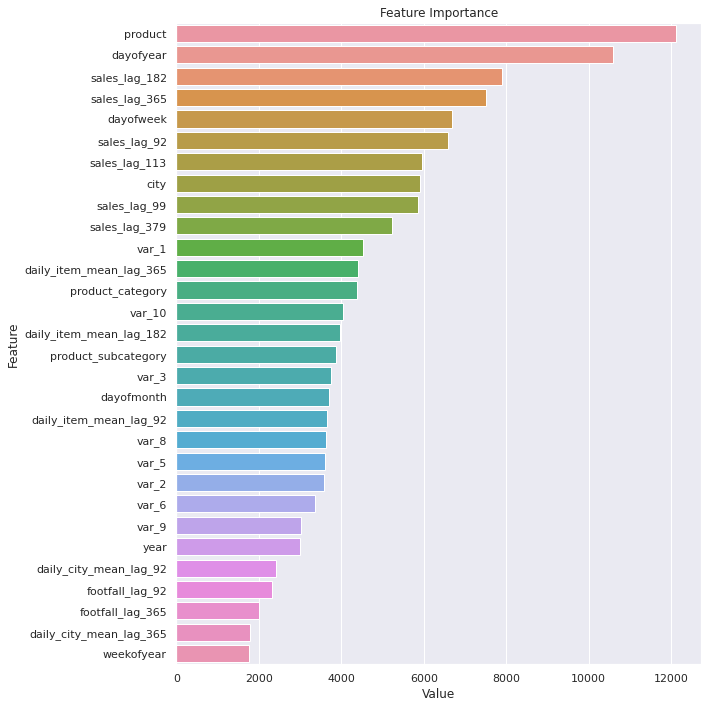

In [45]:
# plot feature importance
feature_imp = pd.DataFrame({'Value':lgb_5_31.feature_importance(),'Feature':combined_df[combined_df.date < '2018-02-01'].drop(['sales','train_or_test','date'], axis=1).columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:30])
plt.title('Feature Importance')
plt.savefig('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/lgbm_importances-01.png')
plt.tight_layout()
plt.show()

In [32]:
y_test.shape

(2262135,)

In [30]:
# converting predictions to pandas dataframe
y_test_pd = pd.DataFrame({'sales': y_test[:,]})

In [33]:
y_test_pd.head()

,sales
0,27.936205
1,32.512355
2,110.549183
3,97.058911
4,20.758135


In [34]:
submission['sales'] = y_test_pd['sales']
submission.head()

,id,sales
0,1,27.936205
1,2,32.512355
2,3,110.549183
3,4,97.058911
4,5,20.758135


In [35]:
submission.tail()

,id,sales
2262130,2262131,31.482028
2262131,2262132,33.328771
2262132,2262133,27.764858
2262133,2262134,70.575475
2262134,2262135,48.460370


In [36]:
# with so many decimal points, csv can become larger than 50MB. rounding to 3 decimal points
submission['sales'] = submission['sales'].round(3)
submission.head()

,id,sales
0,1,27.936
1,2,32.512
2,3,110.549
3,4,97.059
4,5,20.758


In [37]:
# final submission
submission.to_csv('../content/drive/My Drive/Colab Notebooks/bb9f6a4cbd5311ea.zip (Unzipped Files)/Dataset/Lakshay_Vohra_16796_prediction.csv',index=False)